In [93]:
"""
This tutorial shows how to generate adversarial examples using FGSM
and train a model using adversarial training with TensorFlow.
It is very similar to mnist_tutorial_keras_tf.py, which does the same
thing but with a dependence on keras.
The original paper can be found at:
https://arxiv.org/abs/1412.6572
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import functools
from cleverhans import initializers

from tqdm import tqdm
import logging
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import flags

from cleverhans.loss import CrossEntropy
from cleverhans.dataset import MNIST
from cleverhans.utils_tf import model_eval
from cleverhans.train import train
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport, set_log_level, get_log_level
from cleverhans_tutorials.tutorial_models import ModelBasicCNN
from cleverhans.model import Model

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
FLAGS = flags.FLAGS

NB_EPOCHS = 6
BATCH_SIZE = 128
LEARNING_RATE = 0.001
CLEAN_TRAIN = True
BACKPROP_THROUGH_ATTACK = False
NB_FILTERS = 64

In [24]:
class ModelDropoutCNN(Model):
  def __init__(self, scope, nb_classes, nb_filters, input_do = 0.1, **kwargs):
    del kwargs
    Model.__init__(self, scope, nb_classes, locals())
    self.nb_filters = nb_filters
    self.input_do = input_do

    # Do a dummy run of fprop to make sure the variables are created from
    # the start
    self.fprop(tf.placeholder(tf.float32, [128, 28, 28, 1]))
    # Put a reference to the params in self so that the params get pickled
    self.params = self.get_params()

  def fprop(self, x, **kwargs):
    del kwargs
    my_conv = functools.partial(
        tf.layers.conv2d, activation=tf.nn.relu,
        kernel_initializer=initializers.HeReLuNormalInitializer)
    with tf.variable_scope(self.scope, reuse=tf.AUTO_REUSE):
      keep_prob = 1.0 - self.input_do
      y = tf.nn.dropout(x, keep_prob = keep_prob) * keep_prob
      y = my_conv(y, self.nb_filters, 8, strides=2, padding='same')
      y = my_conv(y, 2 * self.nb_filters, 6, strides=2, padding='valid')
      y = my_conv(y, 2 * self.nb_filters, 5, strides=1, padding='valid')
      logits = tf.layers.dense(
          tf.layers.flatten(y), self.nb_classes,
          kernel_initializer=initializers.HeReLuNormalInitializer)
      return {self.O_LOGITS: logits,
              self.O_PROBS: tf.nn.softmax(logits=logits)}

In [94]:
def mnist_tutorial(train_start=0, train_end=60000, test_start=0,
                   test_end=10000, nb_epochs=NB_EPOCHS, batch_size=BATCH_SIZE,
                   learning_rate=LEARNING_RATE,
                   clean_train=CLEAN_TRAIN,
                   testing=False,
                   backprop_through_attack=BACKPROP_THROUGH_ATTACK,
                   nb_filters=NB_FILTERS, num_threads=None,
                   label_smoothing=0.1, input_do = 0.0):
  """
  MNIST cleverhans tutorial
  :param train_start: index of first training set example
  :param train_end: index of last training set example
  :param test_start: index of first test set example
  :param test_end: index of last test set example
  :param nb_epochs: number of epochs to train model
  :param batch_size: size of training batches
  :param learning_rate: learning rate for training
  :param clean_train: perform normal training on clean examples only
                      before performing adversarial training.
  :param testing: if true, complete an AccuracyReport for unit tests
                  to verify that performance is adequate
  :param backprop_through_attack: If True, backprop through adversarial
                                  example construction process during
                                  adversarial training.
  :param label_smoothing: float, amount of label smoothing for cross entropy
  :return: an AccuracyReport object
  """

  tf.reset_default_graph()

  # Object used to keep track of (and return) key accuracies
  report = AccuracyReport()

  # Set logging level to see debug information
  set_log_level(logging.WARNING)

  # Create TF session
  if num_threads:
    config_args = dict(intra_op_parallelism_threads=1)
  else:
    config_args = {}
  config = tf.ConfigProto(**config_args)
  config.gpu_options.per_process_gpu_memory_fraction = 0.5
  config.gpu_options.allow_growth = True
  sess = tf.Session(config=config)

  # Get MNIST data
  mnist = MNIST(train_start=train_start, train_end=train_end,
                test_start=test_start, test_end=test_end)
  x_train, y_train = mnist.get_set('train')
  x_test, y_test = mnist.get_set('test')
    
  input_do_ph = tf.placeholder_with_default(1.0, shape=())

  #print(np.min(x_train), np.max(x_train)) 0.0 1.0

  # Use Image Parameters
  img_rows, img_cols, nchannels = x_train.shape[1:4]
  nb_classes = y_train.shape[1]

  # Define input TF placeholder
  x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols,
                                        nchannels))
  y = tf.placeholder(tf.float32, shape=(None, nb_classes))

  # Train an MNIST model
  train_params = {
      'nb_epochs': nb_epochs,
      'batch_size': batch_size,
      'learning_rate': learning_rate
  }
  eval_params = {
      'batch_size': batch_size
  }

  # making attack single-coordinate
  fgsm_params = {
      'eps': 0.1,
      'clip_min': 0.,
      'clip_max': 1.
  }
  rng = np.random.RandomState([2017, 8, 30])

  def do_eval(preds, x_set, y_set, report_key, is_adv=None):
    acc = model_eval(sess, x, y, preds, x_set, y_set, args=eval_params, feed = {input_do_ph: 0.0})
    setattr(report, report_key, acc)
    if is_adv is None:
      report_text = None
    elif is_adv:
      report_text = 'adversarial'
    else:
      report_text = 'legitimate'
    #if report_text:
      #print('Test accuracy on %s examples: %0.4f' % (report_text, acc))

  if clean_train:
    model = ModelDropoutCNN('model1', nb_classes, nb_filters, input_do = input_do_ph)
    preds = model.get_logits(x)
    loss = CrossEntropy(model, smoothing=label_smoothing)

    def evaluate():
      do_eval(preds, x_test, y_test, 'clean_train_clean_eval', False)

    train(sess, loss, x_train, y_train, evaluate=evaluate,
          args=train_params, rng=rng, var_list=model.get_params(),
          feed = {input_do_ph: input_do})

    # Calculate training error
    if testing:
      do_eval(preds, x_train, y_train, 'train_clean_train_clean_eval')

    # Initialize the Fast Gradient Sign Method (FGSM) attack object and
    # graph
    fgsm = FastGradientMethod(model, sess=sess)
    adv_x = fgsm.generate(x, **fgsm_params)
    preds_adv = model.get_logits(adv_x)

    # Evaluate the accuracy of the MNIST model on adversarial examples
    do_eval(preds_adv, x_test, y_test, 'clean_train_adv_eval', True)

    # Calculate training error
    if testing:
      do_eval(preds_adv, x_train, y_train, 'train_clean_train_adv_eval')

  return report

In [95]:
input_dos = np.linspace(0, 1, 5)
repetitions = 3

In [96]:
input_dos

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [ ]:
import os, sys

# see https://stackoverflow.com/questions/8391411/suppress-calls-to-print-python
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [97]:
def fetch_one(input_do = 0.0):
    """ Get data for once-trained net """
    with HiddenPrints():
        report = mnist_tutorial(input_do = input_do)
    return {'train_adv': report.clean_train_adv_eval, 'train_clean': report.clean_train_clean_eval}

In [98]:
results = [[fetch_one(input_do) for _ in range(repetitions)] for input_do in tqdm(input_dos)]

  0%|          | 0/5 [00:00<?, ?it/s]

num_devices:  2
num_devices:  2
num_devices:  2


 20%|██        | 1/5 [00:34<02:16, 34.09s/it]

num_devices:  2
num_devices:  2
num_devices:  2


 40%|████      | 2/5 [01:09<01:43, 34.40s/it]

num_devices:  2
num_devices:  2
num_devices:  2


 60%|██████    | 3/5 [01:43<01:09, 34.51s/it]

num_devices:  2
num_devices:  2
num_devices:  2


 80%|████████  | 4/5 [02:18<00:34, 34.53s/it]

num_devices:  2
num_devices:  2
num_devices:  2


100%|██████████| 5/5 [02:53<00:00, 34.68s/it]


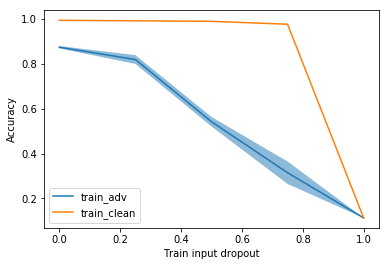

In [99]:
# all keys (assuming for others they are the same)
keys = list(results[0][0].keys())

plt.figure()

# all keys
for key in keys:
    # values for this key
    values = [[x[key] for x in a] for a in results]
    
    # means/stds for values
    means = np.mean(values, axis = 1)
    stds  = np.std (values, axis = 1)
    
    plt.plot(input_dos, means, label = key)
    plt.fill_between(input_dos, means - stds, means + stds, alpha = 0.5)
    
plt.xlabel('Train input dropout')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [92]:
get_log_level

NameError: name 'get_log_level' is not defined